# Tutorial file for the r-place-emergence package

#### imports

In [1]:
import cv2
import PIL as pil
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import json
import pandas as pd
import rplacem.io as rp
matplotlib.rc('axes',edgecolor='black',labelcolor='black')
matplotlib.rc('xtick',color='black')
matplotlib.rc('ytick',color='black')
plt.rcParams['figure.facecolor'] = (1,1,1,0)
fontcolor = [0,0,0]

#### Set some parameters to specify the œuvre of interest and the time stamps at which to look at it

In [2]:
id_name = '000006' # image/artwork id number
file_numbers = np.arange(0,2)# 79 max
time_interval= 0.25 #hrs
total_time = 6 #hrs

#### Get the œuvre pixel changes over time and plot

artwork name: 2b2t
path: {'1-165, T': [[913, 421], [909, 482], [959, 480], [958, 421]]}
data file: 2022_place_canvas_history-000000000000.csv

artwork name: 2b2t
path: {'1-165, T': [[913, 421], [909, 482], [959, 480], [958, 421]]}
data file: 2022_place_canvas_history-000000000001.csv

artwork name: 2b2t
path: {'1-165, T': [[913, 421], [909, 482], [959, 480], [958, 421]]}
artwork name: 2b2t
path: {'1-165, T': [[913, 421], [909, 482], [959, 480], [958, 421]]}
artwork name: 2b2t
path: {'1-165, T': [[913, 421], [909, 482], [959, 480], [958, 421]]}
artwork name: 2b2t
path: {'1-165, T': [[913, 421], [909, 482], [959, 480], [958, 421]]}
artwork name: 2b2t
path: {'1-165, T': [[913, 421], [909, 482], [959, 480], [958, 421]]}
artwork name: 2b2t
path: {'1-165, T': [[913, 421], [909, 482], [959, 480], [958, 421]]}
artwork name: 2b2t
path: {'1-165, T': [[913, 421], [909, 482], [959, 480], [958, 421]]}
artwork name: 2b2t
path: {'1-165, T': [[913, 421], [909, 482], [959, 480], [958, 421]]}
artwork na

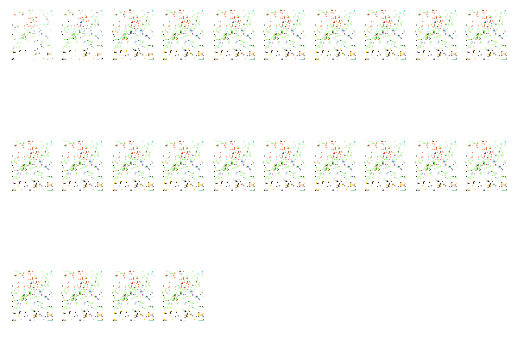

In [3]:
(artwork_pixel_changes_combined,
                 time_inds_list)= rp.show_art_over_time(id_name, 
                                                        file_numbers, 
                                                        time_interval,
                                                        total_time = total_time)

#### Plot the compressed file size ratio (a measure of complexity or disorder) over time

artwork name: 2b2t
path: {'1-165, T': [[913, 421], [909, 482], [959, 480], [958, 421]]}


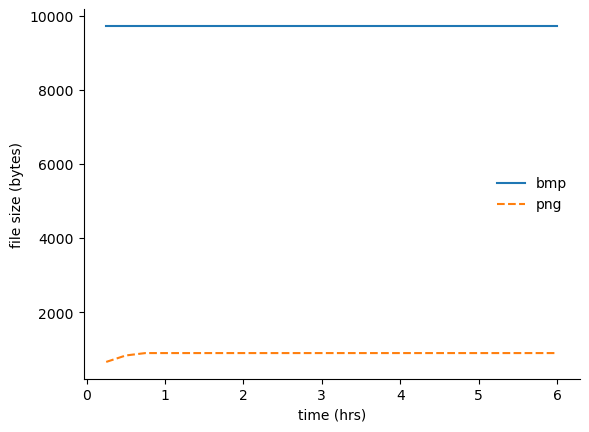

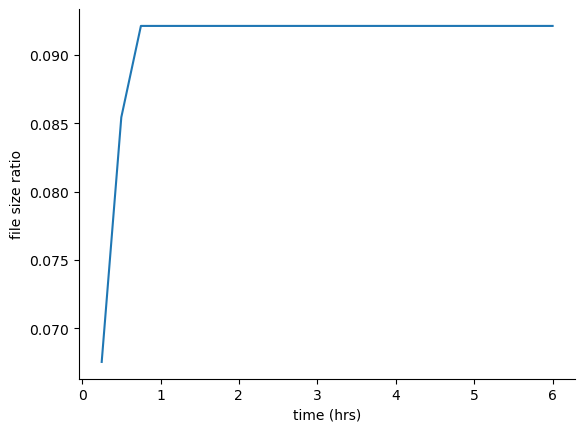

In [4]:
file_size_bmp, file_size_png = rp.save_and_compress_artwork(id_name, artwork_pixel_changes_combined, time_inds_list)

rp.plot_compression(file_size_bmp, file_size_png, time_interval, total_time)